In [7]:
import csv
import cv2
import numpy as np
import sklearn
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import math
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [17]:
samples = []
with open('data/data/driving_log.csv') as csvfile:
    #csvlines = csvfile.readlines()  # if we use this method then comment below 3 lines and replace samples by csvlines
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print (len(samples), len(train_samples), len(validation_samples), samples[550])
a= np.array(samples)

8036 6428 1608 ['IMG/center_2016_12_01_13_33_33_955.jpg', 'IMG/left_2016_12_01_13_33_33_955.jpg', 'IMG/right_2016_12_01_13_33_33_955.jpg', '0', '0.9855326', '0', '30.18664']


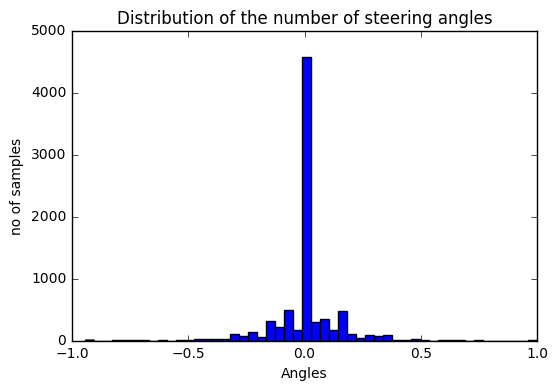

In [18]:
plt.hist(a[:,3].astype(np.float), color = 'b', label = 'train', normed = False, bins=50)
plt.title('Distribution of the number of steering angles')
plt.xlabel('Angles')
plt.ylabel('no of samples')
plt.show()

In [19]:
#car_images = []
#steering_angles = []
i=0

def process_image(image):
    
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/4):shape[0]-25, 0:shape[1]]
    
    
    return image

(95, 320, 3)


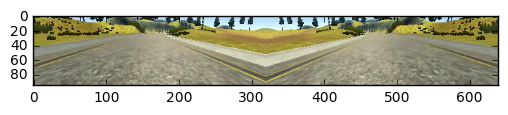

In [38]:
#Sample processing on first image in csv file
path = 'data/data/' # fill in the path to your training IMG directory

#img_center1 = process_image(np.asarray(Image.open(path+csvlines[550][0:38]))) #line[x][0:38], x is row number, [0:38] is characters of first coulmn of that row..
img_center1 = process_image(np.asarray(Image.open(path+samples[550][0])))  #line[x][1], x is row number, [0] is 0th coulmn of that row..
print(img_center1.shape)
img_center1_flipped = np.fliplr(img_center1)
res1 = np.hstack((img_center1,img_center1_flipped))
plt.imshow(res1)
#plt.imshow(img_center1)

In [21]:
def generator(samples, batch_size=64):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            car_images = []
            steering_angles = []
            for row in batch_samples:
                steering_center = float(row[3])

                # create adjusted steering measurements for the side camera images
                correction = 0.1     # this is a parameter to tune
                steering_left = steering_center + correction
                steering_right = steering_center - correction
    
                # read in images from center, left and right cameras
                path = 'data/data/' # fill in the path to your training IMG directory
                img_center = process_image(np.asarray(Image.open(path+row[0])))
                img_center_flipped = np.fliplr(img_center)
                img_left = process_image(np.asarray(Image.open(path+row[1])))
                img_left_flipped = np.fliplr(img_left)
                img_right = process_image(np.asarray(Image.open(path + row[2])))
                img_right_flipped = np.fliplr(img_right)
    
                # add images and angles to data set
                car_images.append(img_center)
                car_images.append(img_center_flipped)
                car_images.append(img_left)
                car_images.append(img_left_flipped)
                car_images.append(img_right)
                car_images.append(img_right_flipped)
                steering_angles.append(steering_center)
                steering_angles.append(-steering_center)
                steering_angles.append(steering_left)
                steering_angles.append(-steering_left)
                steering_angles.append(steering_right)
                steering_angles.append(-steering_right)

            # trim image to only see section with road
            X_train = np.array(car_images)
            y_train = np.array(steering_angles)
            #print(X_train.shape, y_train.shape)
            yield sklearn.utils.shuffle(X_train, y_train)

In [22]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=64)
validation_generator = generator(validation_samples, batch_size=64)

In [23]:
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(95,320,3), output_shape=(95,320,3)))
model.add(Convolution2D(6,5,5, activation="relu"))
model.add(MaxPooling2D())		#or can be MaxPooling2D((2, 2))
model.add(Convolution2D(6,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(75))
model.add(Dense(1))

In [24]:
model.compile(loss='mse', optimizer='adam')
#model.fit(X_train, y_train,validation_split=0.2, shuffle=True, nb_epoch=7)
model.fit_generator(train_generator, samples_per_epoch= \
            len(train_samples)*6, validation_data=validation_generator, \
            nb_val_samples=len(validation_samples)*6, nb_epoch=7)         #https://keras.io/models/sequential/#fit_generator

model.save('model_test.h5')

Epoch 1/7
38568/38568 [==============================] - 81s - loss: 1.1883 - val_loss: 0.0216
Epoch 2/7
38568/38568 [==============================] - 76s - loss: 0.0211 - val_loss: 0.0197
Epoch 3/7
38568/38568 [==============================] - 76s - loss: 0.0191 - val_loss: 0.0178
Epoch 4/7
38568/38568 [==============================] - 76s - loss: 0.0173 - val_loss: 0.0161
Epoch 5/7
38568/38568 [==============================] - 76s - loss: 0.0159 - val_loss: 0.0150
Epoch 6/7
38568/38568 [==============================] - 76s - loss: 0.0146 - val_loss: 0.0142
Epoch 7/7
38568/38568 [==============================] - 76s - loss: 0.0138 - val_loss: 0.0136
